In [1]:
pip install pennylane

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pennylane as qml 
import tensorflow as tf
from pennylane import qchem
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [4]:
class Grover:
    
    def __init__(self, qubits, shots, oracle_state):
        #num of qubits
        self.qubits = qubits
        #num of shots on backend
        self.shots = shots
        #marked state defining the oracle
        self.num = oracle_state
        if oracle_state >= 2**self.qubits:
            raise ValueError(f"Insufficient qubits. Input value less than {2**self.qubits}")
        v = []
        B = bin(oracle_state)[2:].zfill(self.qubits)
        for i in range(len(B)):
            v.append(int(B[i]))
        self.oracle = v
        #optimal number of oracle+diffuser cycles
        self.cycles = int(np.floor(np.sqrt(self.qubits)))
    
    def run(self, cycles = None):
        if cycles is None:
            cycles = self.cycles
        
        #setup
        initial_state = []
        for i in range(self.qubits):
            initial_state.append(1)
            
        #oracle+diffusion
        def OD():
        #oracle
            qml.FlipSign(self.oracle, wires = range(self.qubits))
        #diffusion
            for i in range(self.qubits):
                qml.Hadamard(i)
            qml.FlipSign(initial_state, wires = range(self.qubits))
            for i in range(self.qubits):
                qml.Hadamard(i)
                
        #repeater oracle+diffuser 
        def Oracle_Diffusion(n):
            for i in range(n):
                OD()
                
    #run grover
        dev = qml.device("default.qubit", wires = self.qubits, shots = self.shots)
        @qml.qnode(dev, interface="autograd")
        def G(q):
        #initial state prep
            for i in range(self.qubits):
                qml.PauliX(i)
                qml.Hadamard(i)
        #repeated component
            Oracle_Diffusion(cycles)
        #measurement
            return qml.probs(wires = range(self.qubits))
            #return qml.sample()
        return (G(self.qubits))
        
    def plot(self, cycles = None):
        if cycles is None:
            cycles = self.cycles
            
        y = self.run(cycles)
        bit_strings = [f"{x:0{self.qubits}b}" for x in range(len(y))]
        plt.bar(bit_strings, y, color = "#212121")
        plt.xticks(rotation="vertical")
        plt.xlabel("State label")
        plt.ylabel("Probability Amplitude")
        plt.title("States probabilities amplitudes")
        plt.show()
        
    def opt(self):
        opt = qml.GradientDescentOptimizer(stepsize=0.4)
        
        theta = np.array(0.0, requires_grad=True)
        Prob = [self.run(theta)[self.num]]
        angle = [theta]
    
        max_iterations = 100
        convergence_tolerance = 1e-06
    
        for n in range(max_iterations):
            
            cost = -self.run(theta)[self.num]
            theta, prev_prob = opt.step_and_cost(cost, theta)
        
            Prob.append(self.run(theta)[self.num])
            angle.append(theta)
              
            #conv = np.abs(Prob[-1] - prev_prob)
              
            if n % 2 == 0:
                print(f"Step = {n}, probability = {Prob[-1]:.8f}")
              
            #if conv <= convergence_tolerance:
            #    break

        print("\n" f"Final amplitude of the target state = {Prob[-1]:.8f}")
        print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")        

In [5]:
G = Grover(3, 1000, 2)
#theta = np.array(0.0, requires_grad=True)
#Prob = [G.run(theta)[0]]
#angle = [theta]

In [6]:
G.run()

tensor([0.027, 0.032, 0.788, 0.028, 0.03 , 0.042, 0.026, 0.027], requires_grad=True)

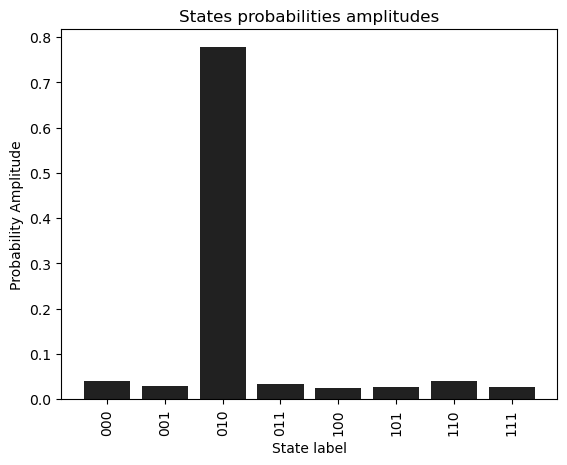

In [7]:
G.plot()

In [ ]:
G.run(1)

tensor([0.86 , 0.004, 0.005, 0.005, 0.001, 0.004, 0.004, 0.002, 0.007,
        0.002, 0.005, 0.005, 0.003, 0.002, 0.005, 0.003, 0.008, 0.004,
        0.006, 0.006, 0.005, 0.008, 0.007, 0.004, 0.004, 0.007, 0.004,
        0.005, 0.003, 0.005, 0.005, 0.002], requires_grad=True)

In [ ]:
G.run(2)

tensor([0.853, 0.004, 0.006, 0.005, 0.002, 0.001, 0.006, 0.002, 0.007,
        0.006, 0.004, 0.003, 0.006, 0.005, 0.005, 0.007, 0.007, 0.001,
        0.003, 0.004, 0.004, 0.01 , 0.004, 0.   , 0.007, 0.006, 0.008,
        0.007, 0.007, 0.004, 0.003, 0.003], requires_grad=True)

In [ ]:
G.run(3)

tensor([0.869, 0.003, 0.003, 0.006, 0.003, 0.007, 0.002, 0.006, 0.005,
        0.011, 0.002, 0.003, 0.002, 0.003, 0.001, 0.008, 0.002, 0.008,
        0.007, 0.006, 0.006, 0.003, 0.005, 0.001, 0.001, 0.003, 0.002,
        0.003, 0.006, 0.005, 0.001, 0.007], requires_grad=True)

In [ ]:
G.run(4)

tensor([0.873, 0.004, 0.004, 0.007, 0.004, 0.004, 0.008, 0.001, 0.002,
        0.004, 0.003, 0.008, 0.006, 0.007, 0.005, 0.002, 0.003, 0.005,
        0.005, 0.   , 0.003, 0.003, 0.003, 0.003, 0.002, 0.004, 0.002,
        0.006, 0.002, 0.005, 0.006, 0.006], requires_grad=True)

In [ ]:
G.run(7)

tensor([0.861, 0.008, 0.001, 0.003, 0.003, 0.003, 0.004, 0.007, 0.009,
        0.009, 0.003, 0.004, 0.004, 0.004, 0.004, 0.006, 0.004, 0.006,
        0.006, 0.002, 0.004, 0.004, 0.002, 0.008, 0.008, 0.003, 0.003,
        0.002, 0.004, 0.004, 0.005, 0.002], requires_grad=True)

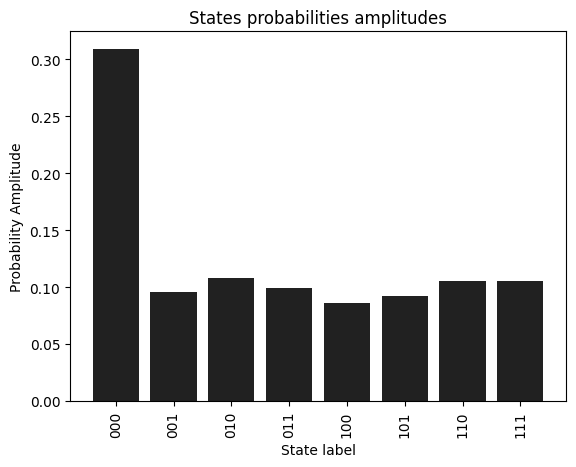

In [ ]:
G.plot(3)

In [ ]:
G = Grover(3, 1000, 0)

In [ ]:
G.run(theta)[G.num]

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)
theta = np.array(0.0, requires_grad=True)
#theta = 0
Prob = [G.run(theta)[G.num]]
angle = [theta]
max_iterations = 100
#        convergence_tolerance = 1e-06
    
for n in range(max_iterations):
    cost = -G.run(theta)[G.num]
    theta, prev_prob = opt.step_and_cost(cost, theta)
        
    Prob.append(cost)
    angle.append(theta)
              
            #conv = np.abs(Prob[-1] - prev_prob)
              
    if n % 2 == 0:
        print(f"Step = {n}, probability = {Prob[-1]:.8f}")
              
            #if conv <= convergence_tolerance:
            #    break

print("\n" f"Final amplitude of the target state = {Prob[-1]:.8f}")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")  

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
np.abs(-3)

3

In [ ]:
Prob

[tensor(0.342, requires_grad=True)]

In [ ]:
prev_prob

NameError: name 'prev_prob' is not defined

In [ ]:
G = Grover(3, 1000, 0)
opt = qml.GradientDescentOptimizer(stepsize=0.4)

#theta = np.array(0.0, requires_grad=True)
theta = [0]
Prob = [G.run(theta)[G.num]]
angle = [theta]
    
max_iterations = 100
convergence_tolerance = 1e-06
    
for n in range(max_iterations):
    cost = -G.run(theta)[G.num]
    theta, prev_prob = opt.step_and_cost(cost, theta)
        
    Prob.append(G.run(theta))
    angle.append(theta)
              
    conv = np.abs(Prob[-1] - prev_prob)
              
    if n % 2 == 0:
        print(f"Step = {n}, probability = {Prob[-1]:.8f}")
              
    if conv <= convergence_tolerance:
        break

print("\n" f"Final amplitude of the target state = {Prob[-1]:.8f}")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}") 

TypeError: 'tensor' object is not callable

In [ ]:
theta

tensor(0., requires_grad=True)

In [ ]:
cost = -G.run(theta)[G.num]

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
cost

tensor(-0.339, requires_grad=True)

In [ ]:
cost[0]

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed